In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

# !pip install openpyxl

In [2]:
github_url = 'https://raw.githubusercontent.com/syifafatma/Dataset-Inflasi/main/data_inflasi.xlsx'

# load dataset from github
my_file = requests.get(github_url)

# save file to buffer and read as pandas
with open('data_inflasi.xlsx', 'wb') as file:
  file.write(my_file.content)
dataset = pd.read_excel(my_file.content, engine='openpyxl')
print(dataset)

<ipython-input-2-faf37f2a0cc9>:9: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  dataset = pd.read_excel(my_file.content, engine='openpyxl')


            Periode Inflasi
0      Oktober 2024  1.71 %
1    September 2024  1.84 %
2      Agustus 2024  2.12 %
3         Juli 2024  2.13 %
4         Juni 2024  2.51 %
..              ...     ...
258      April 2003  7.62 %
259      Maret 2003  7.17 %
260   Februari 2003   7.6 %
261    Januari 2003  8.68 %
262   Desember 2002     0 %

[263 rows x 2 columns]


In [3]:
# sort the data in descending order (bawah ke atas)
dataset = dataset[::-1].reset_index(drop=True)

time_step = np.arange(len(dataset))
inflation = dataset['Inflasi'].str.replace('%', '').astype(float)

time = np.array(time_step)
x = np.array(inflation)

In [4]:
print(time)
print(x)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [5]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
   # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

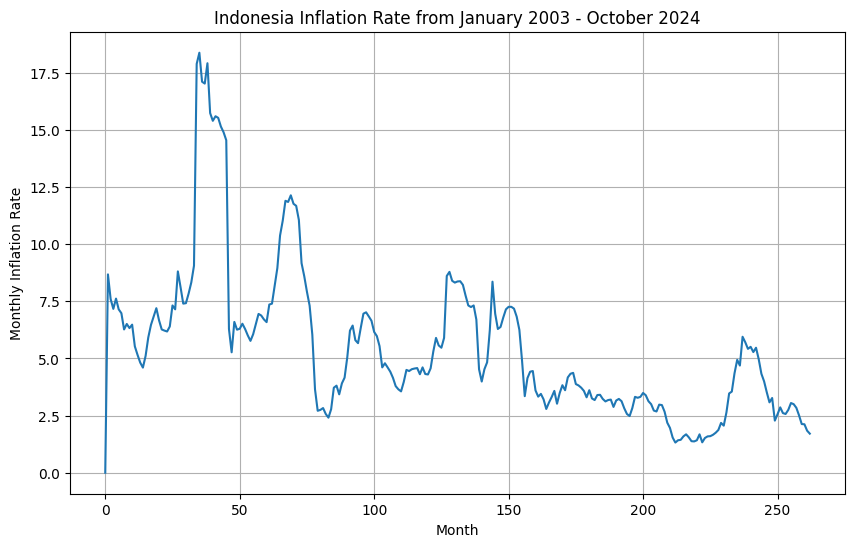

In [6]:
# preview the data
plot_series(time, x, xlabel='Month', ylabel='Monthly Inflation Rate', title='Indonesia Inflation Rate from January 2003 - October 2024')

In [7]:
# split the dataset
split_time = 200

time_train = time[:split_time]
x_train = x[:split_time]

time_valid = time[split_time:]
x_valid = x[split_time:]

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

In [9]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 200

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1,
                           padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 20, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,465 (462.75 KB)

 Trainable params: 118,465 (462.75 KB)

 Non-trainable params: 0 (0.00 B)

saving the best performance model (namely `'inflation_model.keras'`) using `ModelCheckpoint` callbacks

In [11]:
# build and train the dataset
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=150,
                    callbacks=[ModelCheckpoint(filepath='inflation_model.keras',
                                               monitor='mae',
                                               save_best_only=True,
                                               mode='min',
                                               verbose=1
                    )])

Epoch 1/150
     11/Unknown 7s 32ms/step - loss: 4.5858 - mae: 5.0776
Epoch 1: mae improved from inf to 3.97966, saving model to inflation_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 4.4195 - mae: 4.9087
Epoch 2/150


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.9863 - mae: 2.4581
Epoch 2: mae improved from 3.97966 to 2.38174, saving model to inflation_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.9769 - mae: 2.4464
Epoch 3/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8769 - mae: 2.3636
Epoch 3: mae improved from 2.38174 to 2.26657, saving model to inflation_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.8638 - mae: 2.3487
Epoch 4/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.7241 - mae: 2.1989
Epoch 4: mae improved from 2.26657 to 2.04207, saving model to inflation_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7031 - mae: 2.1748
Epoch 5/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.3887 - mae: 1.8242
Epoch 5: mae improved from 2.04207 to 1.67536, saving model to inflation_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.3691 - mae: 1.8013
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.0911 - mae

In [12]:
# model prediction

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)

    return forecast

In [13]:
# Load the saved model
best_model = tf.keras.models.load_model('inflation_model.keras')

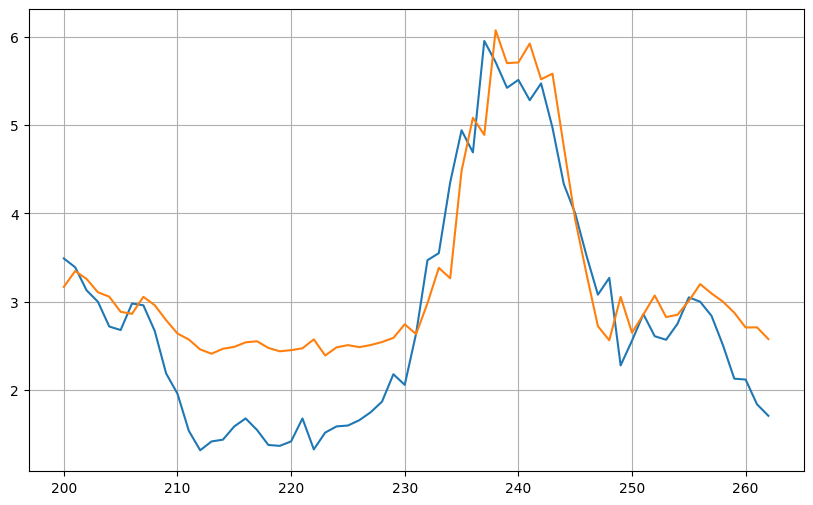

In [14]:
# Reduce the original series
forecast_series = x[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(best_model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

<Figure size 640x480 with 0 Axes>

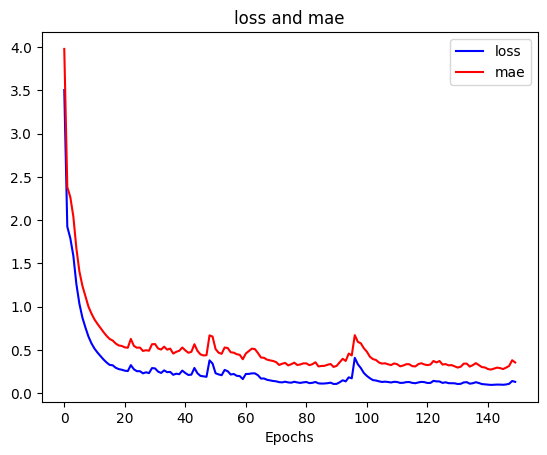

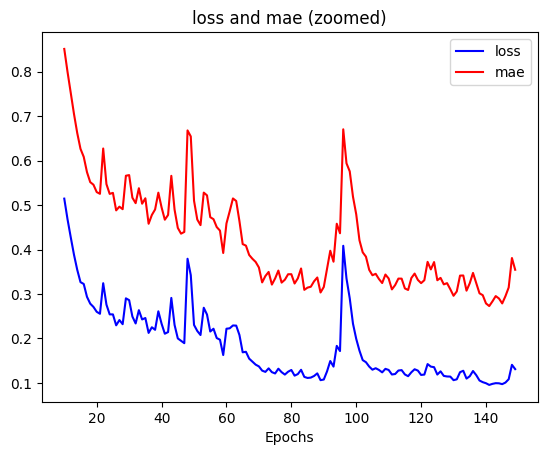

<Figure size 640x480 with 0 Axes>

In [15]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

# Plot the loss and mae
plt.plot(loss, label='loss', color='blue')
plt.plot(mae, label='mae', color='red')
plt.xlabel("Epochs")
plt.legend()
plt.title('loss and mae')
plt.figure()

epochs_zoom = epochs[10:]
mae_zoom = mae[10:]
loss_zoom = loss[10:]

# Plot zoomed loss and mae
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.title('loss and mae (zoomed)')
plt.xlabel("Epochs")
plt.legend(["loss", "mae"])

plt.figure()

In [16]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.5470305


In [20]:
# Save the best model in h5 format
best_model.save('inflation_model.h5')

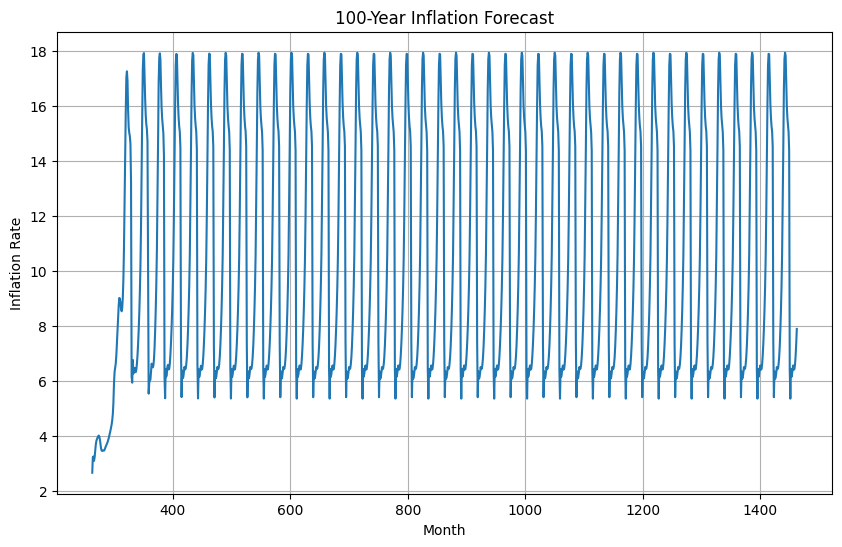

In [18]:
extended_time = np.arange(len(x), len(x) + 1200)
future_forecast_series = x.copy()
results_future = []

for _ in range(1200):
    future_forecast = model_forecast(model, future_forecast_series, window_size, batch_size)
    result_future = future_forecast.squeeze()[-1]
    results_future.append(result_future)
    future_forecast_series = np.append(future_forecast_series, result_future)

# Visualization
plot_series(extended_time, results_future, xlabel='Month', ylabel='Inflation Rate', title='100-Year Inflation Forecast')

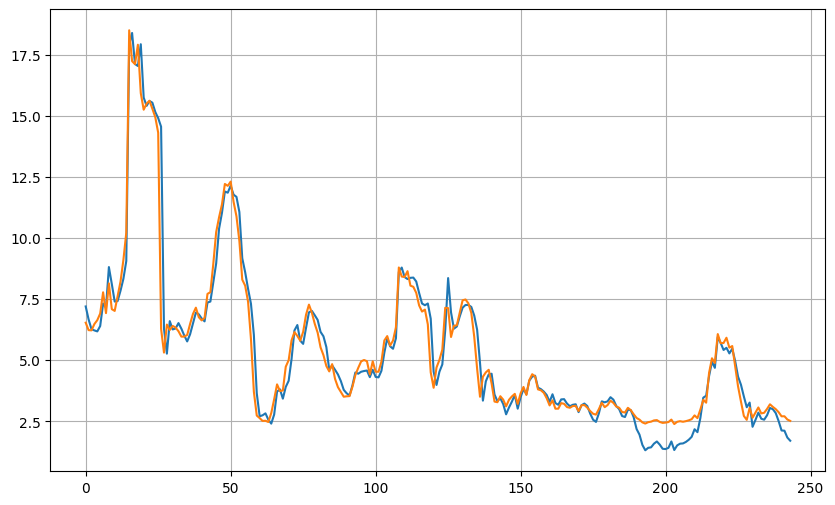

In [19]:
# Reduce the original series
forecast_series_2 = x

# Use helper function to generate predictions
forecast_2 = model_forecast(best_model, forecast_series_2, window_size, batch_size)

# Drop single dimensional axis
results_2 = forecast_2.squeeze()

# Plot the results
plot_series(time[:len(results_2)], (x[19:], results_2))

In [21]:
# Create a DataFrame for the future predictions
future_predictions = pd.DataFrame({'Month': extended_time, 'Inflation Rate': results_future})

start_date = '2024-11-01'
future_predictions['Month'] = pd.date_range(start=start_date, periods=len(future_predictions), freq='M')

# Save the future predictions to a CSV file
future_predictions.to_csv('future_inflation_prediction.csv', index=False)

<ipython-input-21-9de457a08360>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_predictions['Month'] = pd.date_range(start=start_date, periods=len(future_predictions), freq='M')
